# YouTube Virality Category
## IMT 547, Group Number 4
### Anuj Sinha, Megan-Kit Yan Ly, Sungha Kang, Mahir Jain

### Problem
YouTube videos are uploaded by various channels but we do not have any proactive approach in predicting the success (virality) of a video in advance. Considering the fact that more than 80 % used YouTube in 2023 (Pew Research Center, 2023 [1]), it is critical to understand what content does well on YouTube and come up with some form of virality score, which can then be integrated into YouTube content sorting algorithms to promote content which is bound to do well, amongst other use cases. 

### Research Questions

* What content does well on YouTube?
* What is the category of content which does well, and are there any noticeable trends in popularity by content category?
* How can we calculate a virality score of each video, through some form of weighted average of already existing metrics (likes, comments, views, etc) to be able to do a easy comparison between the popularity of different videos.

#### Supplemtal Research Questions (if time permits)
* What is the overall sentiment of comments and is there any relation to the category of content being commented on?
* Build some kind of prediction model that is given the transcript and it can predict the virality score, which can be used by creators to update their content to improve virality before posting

### Data Collection & Approach

1. Selection of YouTube channels to parse video content
    * We selected channels that are popular in their category (having > **1M subscribers**) across categories like comedy, news, music, as well as miscellaneous categories like fitness, how-to and talk shows. These categories are commonly found to be popular on YouTube and are of particular interest for this project (Google Consumer Insights, 2016 [2]))
2. Picking 250 videos from each of the defined channels (**20** in total). This is to ensure uniformity and to avoid selection bias. In addition, we also had to be mindful of the YouTube Data API daily limit of **10000** as well as the bottlenecks including the download of transcripts and the classification of content category using large language models (explained in later steps). We parse this data using the `YouTube Data API` and also collect statistics like the like, video and view counts in addition to the video meta-data (publish time, title, etc)
3. Based on the above selected videos, we download the transcripts using the `YouTubeTranscriptApi`
4. Considering the limit of characters (**4000** characters) for the used large language models, we select the first **4000** characters of the transcript
   * To do a quantitative comparison to ensure that we are not losing on vital information by doing an arbitrary selection on the first **4000** characters, we apply `Vader` sentiment analysis and compare the sentiment for the short and long versions of the transcripts to ensure there is no noticable difference
5. We perform a preliminary cleaning and analysis of the data that we collected and plot the results along with descriptions of the collected data.

### Data Glossary (collected data)

1. `channel_name` - The name of the channel that the video was posted by, which may be an individual contributor or a group
2. `video_id` - Unique identifier of the video in YouTube
3. `video_title` - Title of the posted video
4. `video_description` - Description of the posted video
5. `video_published_at` - Time of the posting of video
6. `video_view_count` - The number of views that the video received, at the itme of collection
7. `video_like_count` - The number of likes that the video received, at the time of collection
8. `video_comment_count` - The number of comments that the video received, at the time of collection
9. `transcript` - The transcript of the entire video, pulled using the `video_id`
10. `short_transcript` - The first 4000 characters of the transcript, specifically for inputting into the LLM
11. `transcript_vader` - The polarity score of the transcript after applying `Vader` sentiment analyzer
12. `short_transcript_vader` - The polarity score of the short transcript after applying `Vader` sentiment analyzer
13. `category` - The transcript category generated by LLM from the pre-provided category list provided in the prompt
14. `llm_category`- The transcript category generated by LLM when prompted without any pre-provided category list.
15. `filtered_category` - Filtered and curated version of `category` obtained after data-cleanup
16. `filtered_llm_category`- Filtered and curated version of `llm_category` obtained after data-cleanup.

### Individual contributions

1. Channel Selection & Research - Megan & Sungha
2. Data collection & transcript download - Mahir
3. Preliminary analysis of collected data - Mahir
4. Content categorization of transcript - Anuj
5. Post-LLM Generation Category Clean-up & Visualization - Anuj
6. Overall Documentation - All

### Challenges

1. `YouTube Data API` has a daily limit of **10000** request, which limits our ability to pull a lot of data, without breaking the collection process into chunks.
2. `YouTubeTranscriptApi` does not perform very well for very large number of videos, and we had to limit the number of videos to **5000** for this data collection step for successful execution
3. Finding YouTube channels which produce cross-category content on a single channel is tough, while this would've been very interesting to analyse
4. The transcripts are not available for each video, and while we start off with a uniform number of videos to extract from each channel, we end up with a non-uniform distribution after processing.
5. The overall sentiment of videos that we have collected at this stage is largely positive (explained later) and while this may have something to do with our choice of channels, we do not usually expect very negative _content_ as this stage of analysis is on the _content_ itself and not the _comments_
6. The LLM-based categorization provided limited-period access to the hugging-face model and several additional setups on a cloud infrastructure like CUDA, memory optimization, and parallel processing.
7. The hugging-face model = "meta-llama/Llama-2-7b-chat-hf" has limitations with the max size of the input token, due to this not all transcripts were getting categorized correctly. We had to use `short_transcript` as input to get the relevant category.
8. Despite the curation and testing of different prompts for LLM, the outputs from the models were not restricted to pre-defined categories in the prompt. The output categories column had 100+ close related categories - which had to be manually curated into less than 20 unique categories.
10. Each record took approx 5 sec on average for output categorization. The script had to run for 12+ hours.
   
   

References - 
1. https://www.pewresearch.org/internet/fact-sheet/social-media/#:~:text=the%20same%20platform.-,Which%20social%20media%20platforms%20are%20most%20common%3F,most%2Dwidely%20used%20online%20platforms.
2. https://www.thinkwithgoogle.com/consumer-insights/consumer-trends/top-content-categories-youtube/
3. https://medium.com/@dmitri.mahayana/creating-virtual-assistance-using-with-llama-2-7b-chat-model-9f693c8250ee

In [1]:
#Importing Required Libraries
!pip install --upgrade google-api-python-client --quiet
import json
import googleapiclient
import googleapiclient.discovery
import googleapiclient.errors
import pandas as pd

In [2]:
path_to_json = "info.json"

with open(path_to_json, "r") as handler:
    info = json.load(handler)

API_KEY = info["API_KEY"]
!pip install --upgrade google-api-python-client --quiet

In [3]:
youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=API_KEY)

### Data Collection

In [4]:
# Video & Metrics collection from YouTube

import datetime
import pandas as pd
from googleapiclient.discovery import build

def download_statistics(username, limit=10, api_key=None):
    
    request = youtube.channels().list(
    part="contentDetails",
    forUsername=username
    )
    
    res = request.execute()
    uploads_playlist_id = res["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
    videos_info = []
    
    request = youtube.playlistItems().list(
        part="snippet",
        playlistId = uploads_playlist_id
        # YOUR SOLUTION
    )
    
    res = request.execute()
    
    page_token = res['nextPageToken'] if res['nextPageToken'] else ""
    for v in res["items"]:
        video_id = v['snippet']['resourceId']['videoId']
            
        # Get video views count
        stats_request = youtube.videos().list(
            part="statistics",
            id=video_id
        )
        stats_res = stats_request.execute()
            
        # Check if statistics are available for the video
        if stats_res['items']:
            statistics = stats_res['items'][0]['statistics']
            view_count = int(statistics.get('viewCount', 0))
            like_count = int(statistics.get('likeCount',0))
            comment_count = int(statistics.get('commentCount',0))
        else:
            view_count = like_count = comment_count = 0
    
        dict_vid = {
            'channel_name': v['snippet']['channelTitle'],
            'video_id': video_id,
            'video_title': v['snippet']['title'],
            'video_description': v['snippet']['description'],
            'video_published_at': v['snippet']['publishedAt'],
            'video_view_count': view_count,
            'video_like_count': like_count,
            'video_comment_count': comment_count
        }
        videos_info.append(dict_vid)

    while page_token and len(videos_info) < limit: # Limiting the number of API calls using the videos_info as the daily limit is exceeding otherwise
        request = youtube.playlistItems().list(
        part="snippet",
        playlistId = uploads_playlist_id,
        pageToken = page_token
    )
        res = request.execute()
        page_token = res['nextPageToken'] if res['nextPageToken'] else ""
    
        for v in res["items"]:
            video_id = v['snippet']['resourceId']['videoId']
            
            # Get video video views count
            stats_request = youtube.videos().list(
                part="statistics",
                id=video_id
            )
            stats_res = stats_request.execute()
            
            # Check if statistics are available for the video
            if stats_res['items']:
                statistics = stats_res['items'][0]['statistics']
                view_count = int(statistics.get('viewCount', 0))
                like_count = int(statistics.get('likeCount',0))
                comment_count = int(statistics.get('commentCount',0))
            else:
                view_count = like_count = comment_count = 0
    
            dict_vid = {
                'channel_name': v['snippet']['channelTitle'],
                'video_id': video_id,
                'video_title': v['snippet']['title'],
                'video_description': v['snippet']['description'],
                'video_published_at': v['snippet']['publishedAt'],
                'video_view_count': view_count,
                'video_like_count': like_count,
                'video_comment_count': comment_count
            }
            videos_info.append(dict_vid)
    print(f"The videos extracted from {username} are: ", len(videos_info))
    return videos_info
    

API_KEY = API_KEY
youtube_channel_1 = [
    "twosetviolin",
    "Vsauce",
    "CNN",
    "moneycontrol",  
    "BBC",     
    "TBS",
    "PewDiePie",
    "SonyMusicIndiaVEVO",
    "wwe",
    "smosh",
    "Vevo",
    "WatchMojo",
    "Wired",
    "BuzzFeedVideo",
    "Vogue",
    "howcast",
    "fitnessblender",
    "CinemaSins",
    "TheEllenShow",
]

export_data = []
try: 
    for channel in youtube_channel_1:
        export_data.extend(download_statistics(channel, limit=250, api_key=API_KEY))
except Exception as e:
    print(e)
    

The videos extracted from twosetviolin are:  250
The videos extracted from Vsauce are:  250
The videos extracted from CNN are:  250
The videos extracted from moneycontrol are:  250
The videos extracted from BBC are:  250
The videos extracted from TBS are:  250
The videos extracted from PewDiePie are:  250
The videos extracted from SonyMusicIndiaVEVO are:  250
The videos extracted from wwe are:  250
The videos extracted from smosh are:  250
The videos extracted from Vevo are:  250
The videos extracted from WatchMojo are:  250
The videos extracted from Wired are:  250
The videos extracted from BuzzFeedVideo are:  250
The videos extracted from Vogue are:  250
The videos extracted from howcast are:  250
The videos extracted from fitnessblender are:  250
The videos extracted from CinemaSins are:  250
The videos extracted from TheEllenShow are:  250


In [5]:
current_datetime = datetime.datetime.now()
transcript_data_path = f"data/transcript_data_{str(current_datetime)}.csv"
pd.DataFrame(export_data).to_csv(transcript_data_path)

In [45]:
!pip install youtube-transcript-api --quiet
from youtube_transcript_api import YouTubeTranscriptApi

### Transcript Download

In [46]:
# https://stackoverflow.com/questions/18603270/progress-indicator-during-pandas-operations
# Transcript download
!pip install tqdm --quiet
from tqdm.auto import tqdm
tqdm.pandas()


transcript_data = pd.read_csv(transcript_data_path)

# Function to get transcript for a given video_id
def get_transcript(video_id):
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        return ' '.join([entry['text'] for entry in transcript])
    except Exception as e:
        return None

# Apply the function to create a new 'transcript' column
transcript_data['transcript'] = transcript_data['video_id'].progress_apply(get_transcript) # lengthy operation so we want to see the progress
transcript_data.to_csv(transcript_data_path)
transcript_data.head()

    
    


  0%|          | 0/4750 [00:00<?, ?it/s]

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,channel_name,video_id,video_title,video_description,video_published_at,video_view_count,video_like_count,video_comment_count,transcript
0,0,0,0,TwoSetViolin,vcitUfPx8jU,Bradley Cooper didn’t practice 40 hrs 😬,he may be an oscar nominee but can he escape u...,2024-02-16T15:00:58Z,18949,3008,262,hello everyone welcome to another episode of t...
1,1,1,1,TwoSetViolin,sEHQe2TJrxI,wake up babe new viola joke just dropped,Remember to GO PRACTICE. \n___________________...,2024-02-15T13:00:46Z,42901,4008,39,I want everyone to tell me a viola joke I like...
2,2,2,2,TwoSetViolin,duqlRoxoO-0,When you’re a talented musician but she’s LING...,Remember to GO PRACTICE. \n___________________...,2024-02-14T13:00:27Z,93800,7306,49,[Music] so can I just say every Orchestra musi...
3,3,3,3,TwoSetViolin,oJG0QUdOiDo,he really considered it... 😛,Remember to GO PRACTICE. \n___________________...,2024-02-13T13:15:06Z,69409,4418,63,honestly Everything feels so clean clean very ...
4,4,4,4,TwoSetViolin,OqifbSBS560,He didn’t even care 🥲,NaN,2024-02-11T10:44:54Z,118501,11604,225,oh hey BR um I'm going to go rehearsal with Ke...


In [54]:
transcript_data = transcript_data.loc[:, ~transcript_data.columns.str.contains('^Unnamed')] # Cleaning up
transcript_data = transcript_data.dropna(subset=['transcript']) # Since this is the primary column of interest, null values are not acceptable
transcript_data['transcript'].isnull().sum()

0

### Data Processing & Summary Statistics

In [55]:
def shorten_transcript(text):
    if len(text) < 4000: 
        return text # already within limits
    else:
        return text[0:3999]

transcript_data['short_transcript'] = transcript_data['transcript'].apply(shorten_transcript)

In [56]:
transcript_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3625 entries, 0 to 4749
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0.2         3625 non-null   int64 
 1   Unnamed: 0.1         3625 non-null   int64 
 2   Unnamed: 0           3625 non-null   int64 
 3   channel_name         3625 non-null   object
 4   video_id             3625 non-null   object
 5   video_title          3625 non-null   object
 6   video_description    3505 non-null   object
 7   video_published_at   3625 non-null   object
 8   video_view_count     3625 non-null   int64 
 9   video_like_count     3625 non-null   int64 
 10  video_comment_count  3625 non-null   int64 
 11  transcript           3625 non-null   object
 12  short_transcript     3625 non-null   object
dtypes: int64(6), object(7)
memory usage: 396.5+ KB


In [57]:
transcript_data.describe()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,video_view_count,video_like_count,video_comment_count
count,3625.000000,3625.000000,3625.000000,3.625000e+03,3.625000e+03,3625.000000
mean,2528.542345,2528.542345,2528.542345,1.301179e+06,6.488317e+04,2273.423724
std,1470.920654,1470.920654,1470.920654,4.648680e+06,2.185492e+05,8260.325136
min,0.000000,0.000000,0.000000,6.900000e+01,0.000000e+00,0.000000
25%,1147.000000,1147.000000,1147.000000,1.016700e+04,2.130000e+02,8.000000
50%,2887.000000,2887.000000,2887.000000,5.625400e+04,1.322000e+03,58.000000
75%,3819.000000,3819.000000,3819.000000,5.290800e+05,2.162000e+04,980.000000
max,4749.000000,4749.000000,4749.000000,1.297460e+08,6.793075e+06,210874.000000


### Comparison of sentiment in Short & Long transcript

Below, we apply the `Vader` sentiment analyzer to compare the overall sentiment of the short and long versions of the transcript to ensure that our arbitrary selection of the first 4000 characters does not cause the sentiment of the data to be lost, which if correct, we are roughly equating to the category of the content being retained.

In [58]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import string

#nltk.download('punkt') 
#nltk.download('stopwords') 

def clean_text(text):
    # Lowercasing
    text = str(text)
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)
    
    # Removing punctuation and special characters
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    # Removing numbers
    words = [word for word in stripped if word.isalpha()]

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    
    return ' '.join(words)

# Applying the cleaning text function to all the text columns for analysis in our data
transcript_data[['transcript','short_transcript']] = transcript_data[['transcript','short_transcript']].apply(lambda x: x.map(clean_text))

In [62]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob 
import empath

lexicon = empath.Empath()

def analyze_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)['compound']

transcript_data['trancript_vader'] = transcript_data['transcript'].apply(analyze_vader)
transcript_data['short_trancript_vader'] = transcript_data['transcript'].apply(analyze_vader)


# Extract sentiment labels using the quantitative metrics
vader_labels_transcript = transcript_data['trancript_vader'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')
vader_labels_short_transcript = transcript_data['short_trancript_vader'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

In [89]:
sentiment_counts_short_transcript = vader_labels_short_transcript.value_counts()
sentiment_counts_long_transcript = vader_labels_transcript.value_counts()
vader_labels_counts_short = pd.Series(sentiment_counts_short_transcript)
vader_labels_counts_long = pd.Series(sentiment_counts_long_transcript)

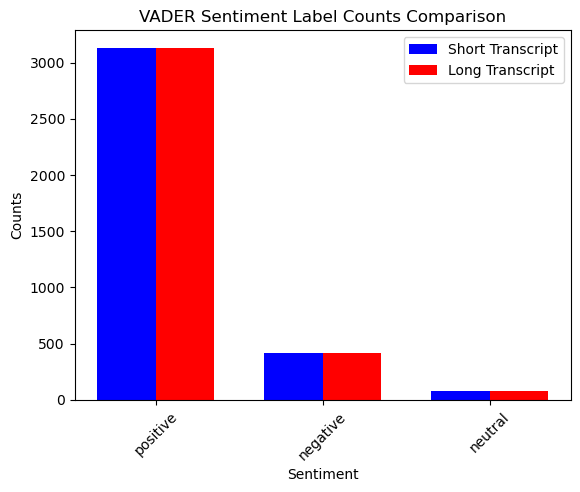

In [98]:
import numpy as np
import matplotlib.pyplot as plt
# Set the positions and width for the bars
positions = np.arange(len(vader_labels_counts_short))
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(positions - width/2, vader_labels_counts_short, width, label='Short Transcript', color='blue')
bars2 = ax.bar(positions + width/2, vader_labels_counts_long, width, label='Long Transcript', color='red')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Sentiment')
ax.set_ylabel('Counts')
ax.set_title('VADER Sentiment Label Counts Comparison')
ax.set_xticks(positions)
ax.set_xticklabels(vader_labels_counts_short.index, rotation=45)
ax.legend()

plt.show()

As we see above, we get an identical distribution of sentiments in the case of short and long transcripts which means that we can approximate that the content category would also remain the same, when we input the shorter version of the transcript into the large language model.

In [77]:
transcript_data['channel_name'].value_counts()

channel_name
CinemaSins        250
FitnessBlender    250
Smosh             250
TheEllenShow      249
WatchMojo.com     248
WIRED             246
PewDiePie         243
British Vogue     240
BuzzFeedVideo     239
Vsauce            235
BBC               234
Howcast           226
TwoSetViolin      220
TBS               178
moneycontrol      163
CNN               150
Vevo                4
Name: count, dtype: int64

As explained above, we are unable to fetch the transcript of all the videos hence there is an unequal number of videos in each channel, however this is something that is hard to control as we started off with a uniform number of videos per channel

/Users/mahirjain/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


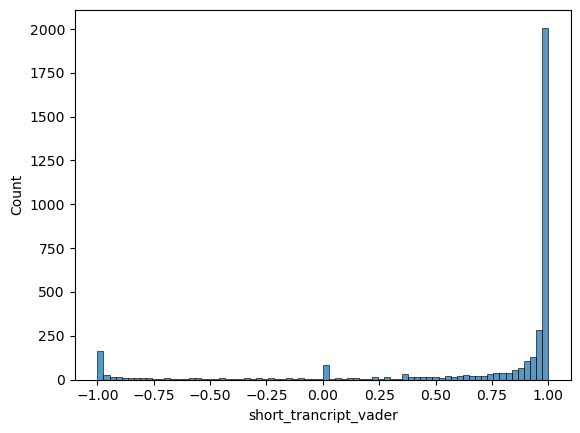

In [86]:
import seaborn as sns
sns.histplot(data=transcript_data, x="short_trancript_vader")
plt.show()

While not an immediate concern, we notice a skewed distribution for the polarity score sourced from applying `Vader` to the transcripts, where we get a skewed and unequal distribution and if needed, we will revisit the set of channels selected to see if we can reduce the skew for polarity scores in our dataset.

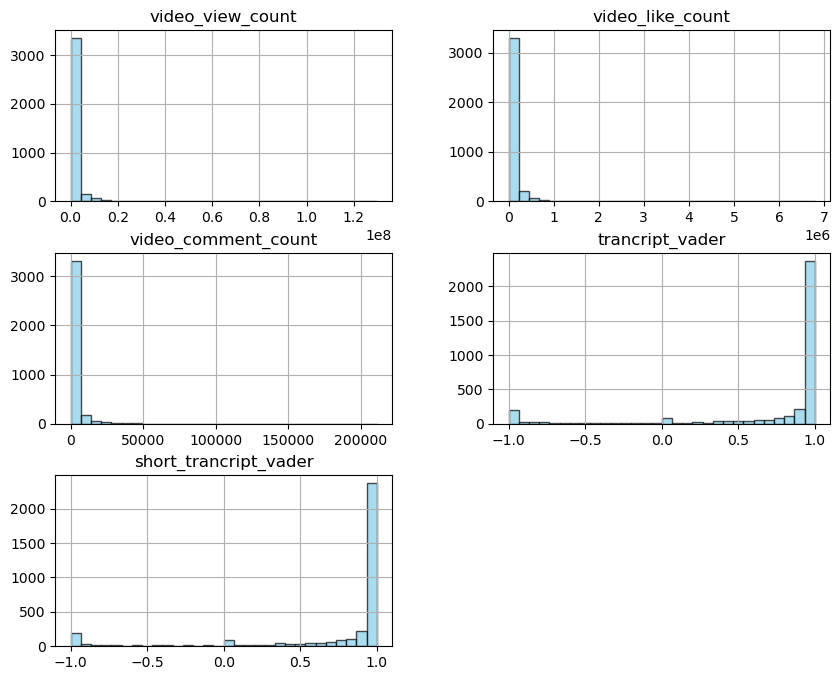

In [103]:
fig = transcript_data.hist(figsize=(10, 8), bins=30, color='skyblue', edgecolor='black', alpha=0.7)

We notice a skewed distribution for the likes, videos and views which means that we will have to perform some kind of normalization to accounts for the subscriber counts across channels as well as possibly apply a log transform to improve the accuracy of our results, but we leave the data as is for a first iteration into the pipeline and we can revisit this step later. 


In [78]:
transcript_data.to_csv(transcript_data_path)

## Category Prediction Via LLM

We used the model:  **"meta-llama/Llama-2-7b-chat-hf"** from hugging-face to run on each of the transcript.
The scripts used for running the prediction model are provided as an **appendix link** along with the submission.
 - generate.ipynb
 - prompts.py

Post Generation Cleanup:

- cleanup.py



#### Visualization Post Category Prediction

In [6]:
import pandas as pd
cleaned_data = pd.read_csv('final.csv')

#### LLM Generated Columns:
- 'category' and 'filtered_category'
- 'llm_category' and 'filterd_llm_category'

In [18]:
cleaned_data.head(5)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,channel_name,video_id,video_title,video_description,video_published_at,video_view_count,video_like_count,video_comment_count,transcript,short_transcript,trancript_vader,short_trancript_vader,category,llm_category,filtered_category,filtered_llm_category
0,0,0,0,TwoSetViolin,vcitUfPx8jU,Bradley Cooper didn’t practice 40 hrs 😬,he may be an oscar nominee but can he escape u...,2024-02-16T15:00:58Z,18949,3008,262,hello everyone welcome another episode two set...,hello everyone welcome another episode two set...,0.9997,0.9997,Music,Classical Music,Entertainment,Entertainment
1,1,1,1,TwoSetViolin,sEHQe2TJrxI,wake up babe new viola joke just dropped,Remember to GO PRACTICE. \n___________________...,2024-02-15T13:00:46Z,42901,4008,39,want everyone tell viola joke like well uh say...,want everyone tell viola joke like well uh say...,0.9712,0.9712,Comedy,Comedy,Movies,Entertainment
2,2,2,2,TwoSetViolin,duqlRoxoO-0,When you’re a talented musician but she’s LING...,Remember to GO PRACTICE. \n___________________...,2024-02-14T13:00:27Z,93800,7306,49,music say every orchestra musician literally e...,music say every orchestra musician literally e...,0.9062,0.9062,Music,Entertainment,Entertainment,Entertainment
3,3,3,3,TwoSetViolin,oJG0QUdOiDo,he really considered it... 😛,Remember to GO PRACTICE. \n___________________...,2024-02-13T13:15:06Z,69409,4418,63,honestly everything feels clean clean clean qu...,honestly everything feels clean clean clean qu...,0.7351,0.7351,Politics,Humor,Politics,Emotion
4,4,4,4,TwoSetViolin,OqifbSBS560,He didn’t even care 🥲,NaN,2024-02-11T10:44:54Z,118501,11604,225,oh hey br um going go rehearsal kevin right ok...,oh hey br um going go rehearsal kevin right ok...,0.9637,0.9637,Music,Music,Entertainment,Entertainment


#### The Below plot shows the categories that were directly generated by the LLM. 

These outputs are reported in the column named 'llm_category'. These columns were further processed in `cleanup.py` to generate the below plots. 

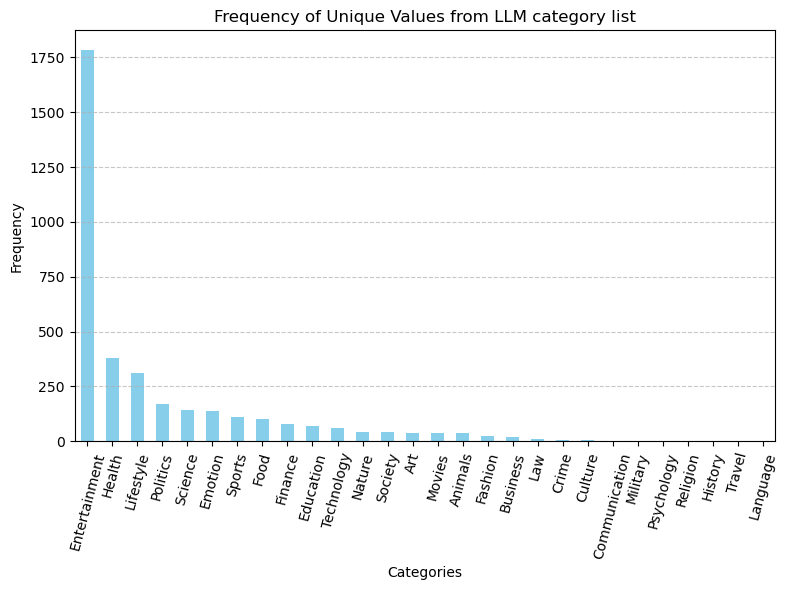

In [19]:
value_counts = cleaned_data['filtered_llm_category'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Unique Values from LLM category list')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=75)  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### After Grouping together similar categories and running LLM Model on pre-categorized list.

The Below plot shows the categories that were generated from the pre-provided LLM scope.. 

These outputs are reported in the column named 'llm_category'. These columns were further processed in `cleanup.py` to generate the below plots. The pre-defined categories are presented on the  x-axis of the below plot. The frequencu count for each category is represented on the y-axis.

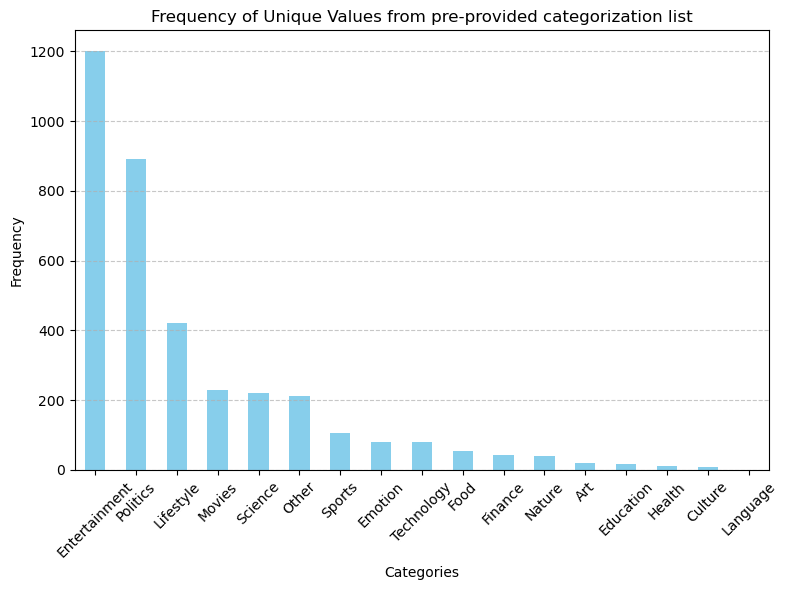

In [20]:
import matplotlib.pyplot as plt
value_counts = cleaned_data['filtered_category'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Unique Values from pre-provided categorization list')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Next Steps:
Now based on the above plot, our next step is to use the cleaned_data to do further analysis based on metrics such as likes, comments, shares, and subscribers. This will be covered in the later phases on the final project.